In [5]:
import csv
import PIL
import matplotlib.pyplot as plt
import cocpit
from cocpit.interpretability.runner import Interp 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
%load_ext autoreload
%autoreload 2

In [6]:
def plot_image(image, ax, date, station) -> None:
    """
    display the raw image

    Args:
        image (PIL.Image.Image): opened image
        ax1 (plt.Axes): subplot axis
    """
    ax.imshow(image, aspect="auto")
    ax.set_title(
            f"Model Labeled as: {row[1]}, {row[2]}, {station}, {date}\n"
        )
    ax.axis("off")


In [7]:
def precip_diff(df) -> None:
    """
    Calculate precip over 5 min observations
    precip - since 00UTC every 5 mins
        resets to 0 at 00:05:00 or 00:00:00
    precip-total - Total Accumulated NRT (mm):
        Accumulated total non real time precipitation
        since the Pluvio started operation with a fixed delay of 5 minutes
    """
    # df = df.reset_index()
    # df = df.sort_values(by=["station", "time_5M"])
    df["precip_diff"] = df["precip"] - df["precip"].shift(1)

    # mask and drop negative precip diff values from gauge resetting for new day
    df = df.mask(df["precip_diff"] < 0, np.nan).dropna(
        subset=["precip_diff"]
    )
    return df

In [8]:
def date_from_filename(filename):
    year = filename[:4]
    month = filename[4:6]
    day = filename[6:8]
    hour = filename[9:11]
    minute = filename[11:13]
    second = '00'
    date_match = f'{year}-{month}-{day} {hour}:{minute}:{second}'
    return pd.to_datetime(date_match, format='%Y-%m-%d %H:%M:%S')

/home/vanessa/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


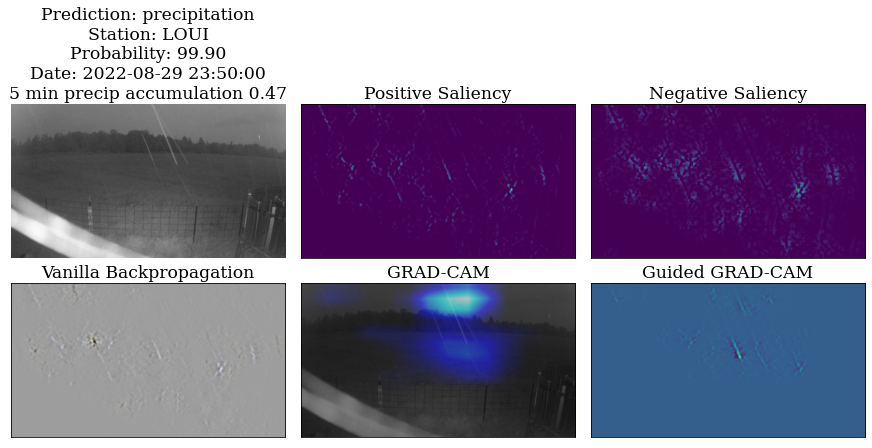

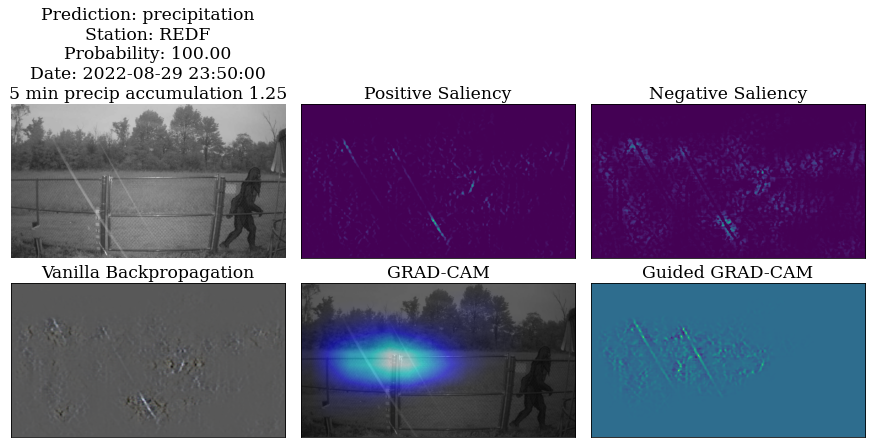

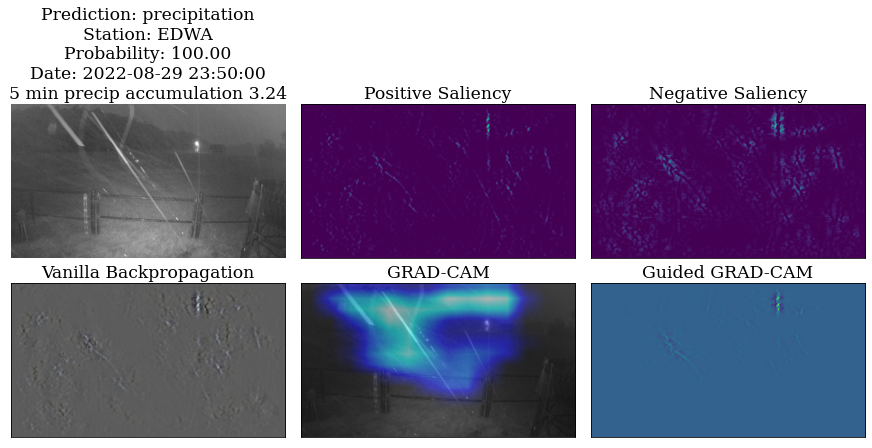

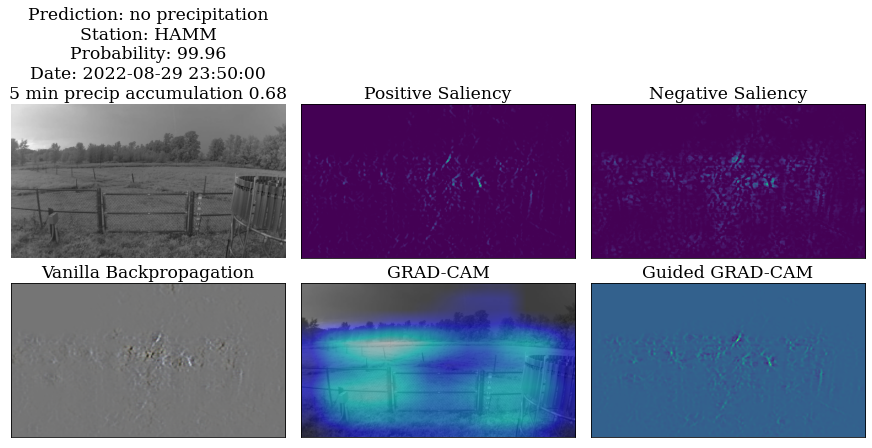

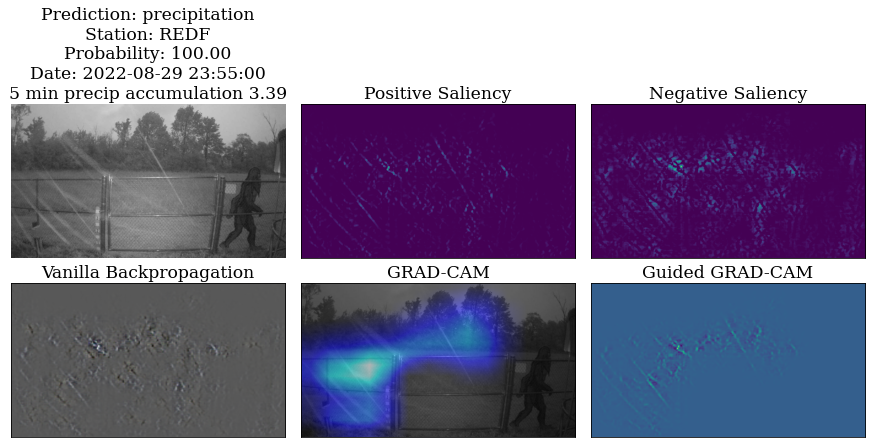

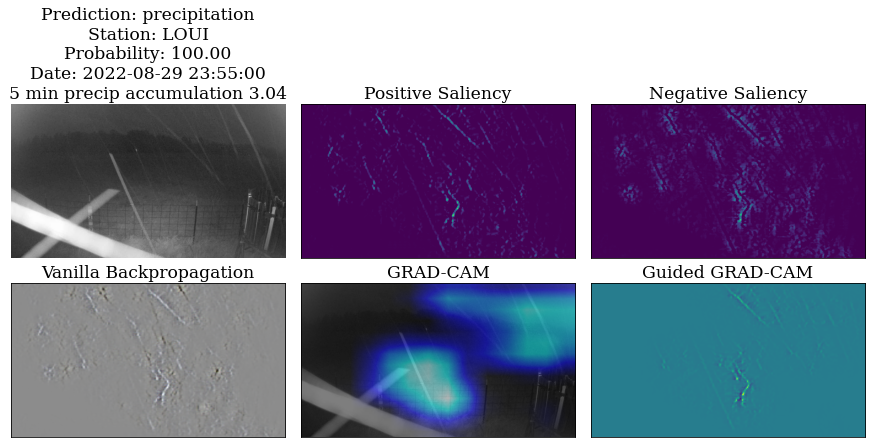

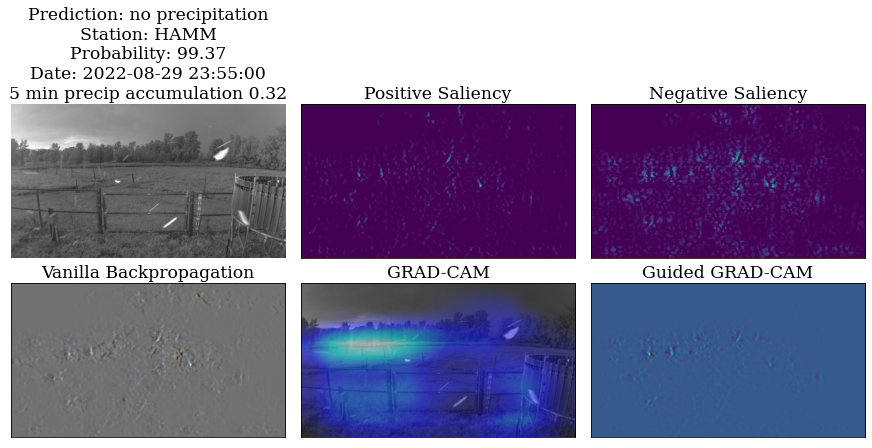

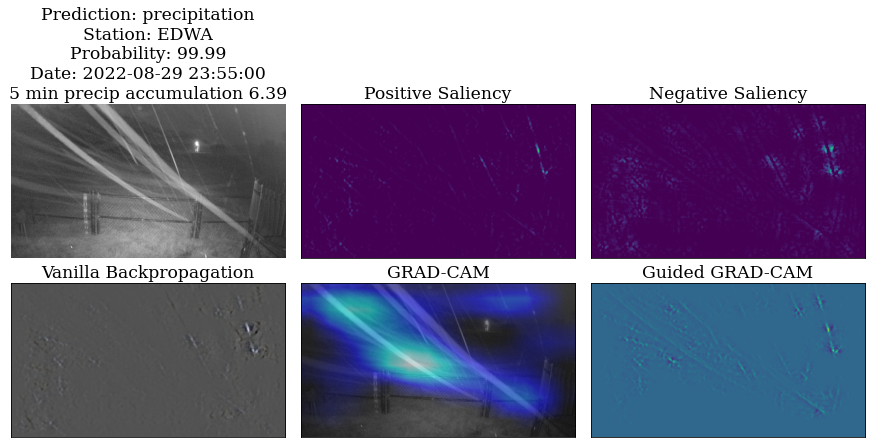

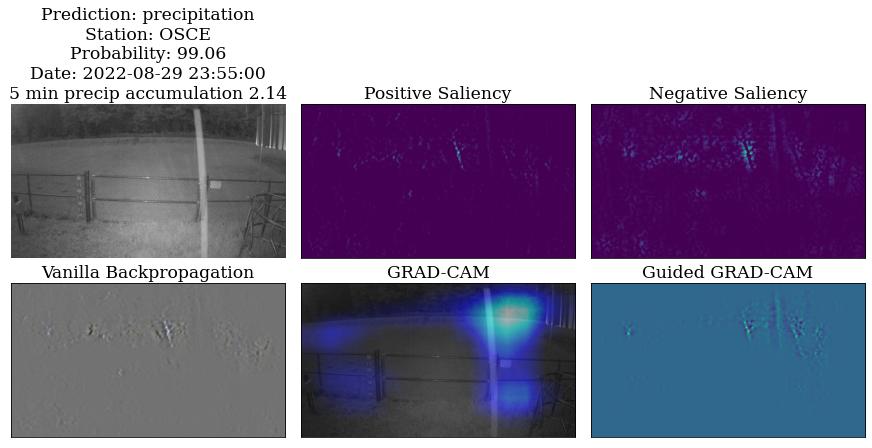

In [9]:
date = '2022/08/29'
year = date.split('/')[0]
month = date.split('/')[1]
day = date.split('/')[2]
ds = xr.open_dataset(f'/ai2es/5_min_obs/{year}/{month}/{year}{month}{day}.nc').to_dataframe()
ds = precip_diff(ds).reset_index()
pred_dir = '/ai2es/realtime_predictions/csv'

pred = 'precipitation'
with open(f"{pred_dir}/{date}/{date.replace('/','_')}.csv", newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    # reader.__next__() # skip header
    for row in reader:
        station = row[0].split('.')[0].split('_')[1]
        date_to_match = date_from_filename(row[0])
        precip = ds['precip_diff'][(ds['station']==station) & (ds['time_5M'] == date_to_match)].item()
        if precip > 0.00:# and row[1] != 'precipitation':
            image = PIL.Image.open(f'/ai2es/cam_photos/{date}/{station}/{row[0]}')
            i = Interp(image, label=row[1], prob=row[2], station=station, date=date_to_match, precip=f'{precip:.2f}')
            i.interp()